In [1]:
!pip install --upgrade pip
!pip install wheel
!sudo apt-get update
!sudo apt-get install gfortran -y
!sudo apt install make -y
!pip install camb
!pip install sbi
!pip install torch
!pip install healpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 3.3 MB/s eta 0:00:00
Get:1 file:/etc/apt/mirrors/debian.list Mirrorlist [30 B]
Get:3 file:/etc/apt/mirrors/debian-security.list Mirrorlist [39 B]     
Get:7 https://packages.cloud.google.com/apt google-compute-engine-bookworm-stable InRelease [5146 B]
Get:2 https://deb.debian.org/debian bookworm InRelease [151 kB]
Get:8 https://packages.cloud.google.com/apt cloud-sdk-bookworm InRelease [6406 B]
Get:4 https://deb.debian.org/debian bookworm-updates InRelease [55.4 kB]
Get:5 https://deb.debian.org/debian bookworm-backports InRelease [56.5 kB]
Get:6 https://deb.debian.org/debian-security bookworm-security InRelease [48.0 kB]
Get:9 https://packages.cloud.google.com/apt google-compute-engine-bookworm-stable/m

In [3]:
import camb
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np
import healpy as hp
from tqdm import tqdm
import pickle

# Set the parameters for the CAMB simulation
def sim(params):
    # Create a set of cosmological parameters
    pars = camb.CAMBparams()
    H0 = params[0] * 100
    As = 1e-10*np.exp(params[3])
    pars.set_cosmology(H0=H0, ombh2=params[1], omch2=params[2])
    pars.InitPower.set_params(As=As, ns=params[4])
    pars.set_for_lmax(2500, lens_potential_accuracy=0)

    # Get the results from CAMB
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)
    total = powers['total']
    cl = total[:, 0]
    nside = 1024
    cmb_map = hp.sphtfunc.synfast(cl, nside=nside)
    cl_hat = hp.sphtfunc.anafast(cmb_map)

    return cl_hat[2:2500]

def finite_derivative_calc_update(fiducial_vals, size):
    derivatives = []
    for i in tqdm(range(5)):
        step = size[i]
        parr = fiducial_vals.copy()
        parr[i] = fiducial_vals[i] + step
        parr2 = fiducial_vals.copy()
        parr2[i] = fiducial_vals[i] - step
        cl1 = sim(parr)
        cl2 = sim(parr2)
        derivative = (cl1 - cl2)/(2*step)
        derivatives.append(derivative.tolist())
    return derivatives

fiducial_values = [0.674,  0.0224,  0.120, 3.08, 0.965]
finite_param_steps = [0.0025, 0.0002, 0.0005, 0.0001, 0.001]
fiducial_cls = sim(fiducial_values)
#finite_derivative = finite_derivative_calc_update(fiducial_values, finite_param_steps)

def cov_matrix(vals):
    ells = np.arange(2561)[2:2500]
    V = np.diag(vals**2) * 2 / ((2*ells+1))
    return V

def MOPED(obs):
    obs = obs
    d_minus_mu = obs - fiducial_cls
    d_minus_mu_vector = [[i] for i in d_minus_mu ]
    inverse_cov_matrix = np.linalg.inv(cov_matrix(obs))
    term1 = np.matmul(inverse_cov_matrix, d_minus_mu_vector)
    compressed_stat = np.matmul(finite_derivative, term1)
    result =  [item[0] for item in compressed_stat]
    return result

# Define your simulation function
def simulation_wrapper(params):
    return MOPED(sim(params))
# Your observed parameter values
observed_params = torch.tensor([0.676, 0.0220, 0.122, 3.085, 0.964])

# Generate the observed dataset
observed_dataset = simulation_wrapper(observed_params)
print(observed_dataset )

[63952.655862172076, -839350.7896613248, 222643.44815195948, -32795.990654657544, -35467.12993469055]


Running 3000 simulations.: 100%|██████████| 3000/3000 [8:57:58<00:00, 10.76s/it]


 Neural network successfully converged after 275 epochs.

Drawing 100000 posterior samples: 100861it [00:00, 156186.48it/s]               


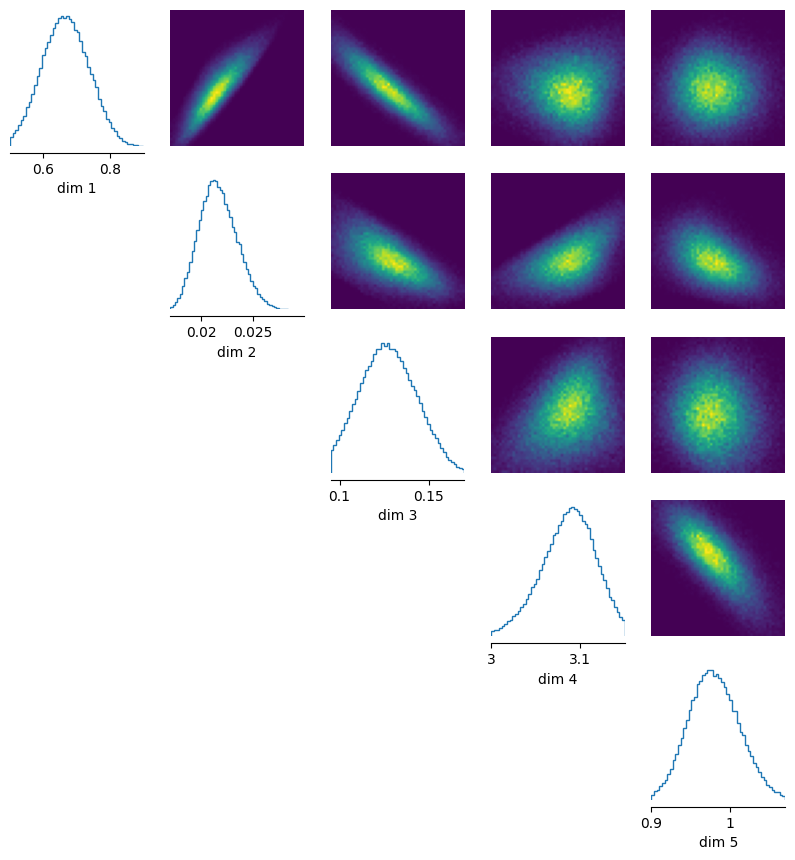

In [4]:
parameter_min = [0.50, 0.017, 0.095, 3.00, 0.9]
parameter_max = [0.90, 0.03, 0.17,3.15, 1.07]

# Define prior for all parameters
prior = utils.BoxUniform(low=torch.as_tensor(parameter_min),
                         high=torch.as_tensor(parameter_max))

num_sim = 3000
# Run SBI to perform inference
posterior = infer(simulation_wrapper, prior, method='SNPE',
                  num_simulations=num_sim, num_workers=1)

num_samples = 100000
# Draw samples from the posterior
samples = posterior.sample((num_samples,), x=observed_dataset)

np.save(f'sbi_moped_{num_sim}_{num_samples}_noisy.npy', samples)

with open(f'posterior_{num_sim}_SNPE_moped_noisy.pkl', 'wb') as file:
    pickle.dump(posterior, file)

# Analyze the results (for example, by plotting the posterior)
limits_plot = [[parameter_min[i], parameter_max[i]] for i in range(len(parameter_min))]
_ = analysis.pairplot(samples, limits=limits_plot,
                      figsize=(10,10))

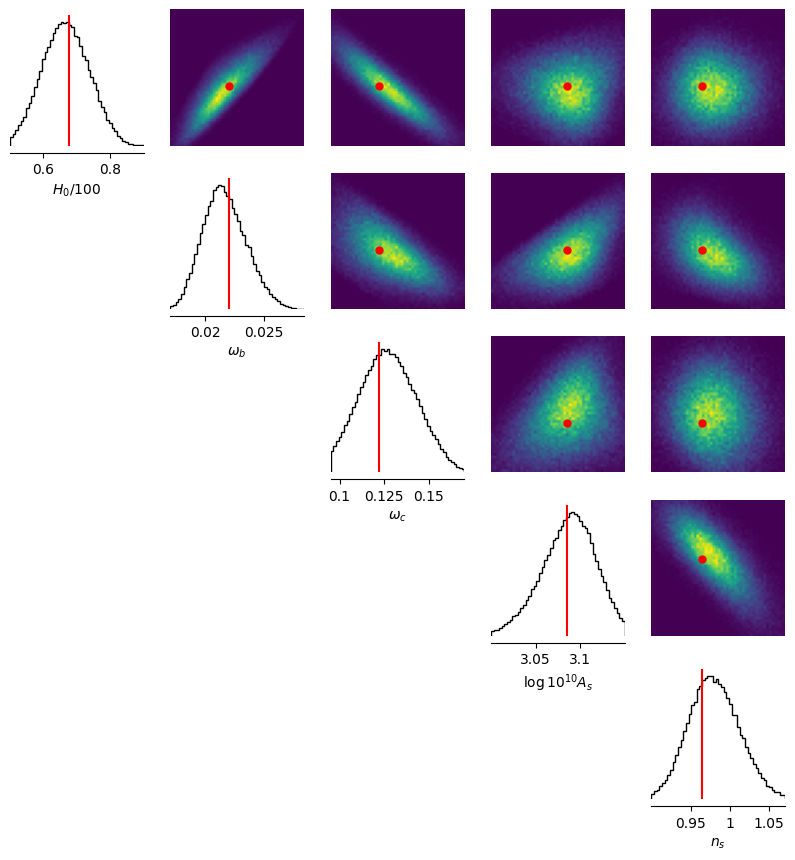

In [6]:
_ = analysis.pairplot(samples, figsize=(10,10), points = torch.tensor([0.676, 0.0220, 0.122, 3.085, 0.964]),
                     points_colors = 'red', samples_colors = 'k', offdiag = 'hist',labels=[r"$H_0 / 100$", r"$\omega_b$", r'$\omega_c$', r'$\log 10^{10} A_s$',
                                                                     r'$n_s$'])

In [8]:
samples_noisy = np.load('sbi_noisy_200k.npy', allow_pickle = True)

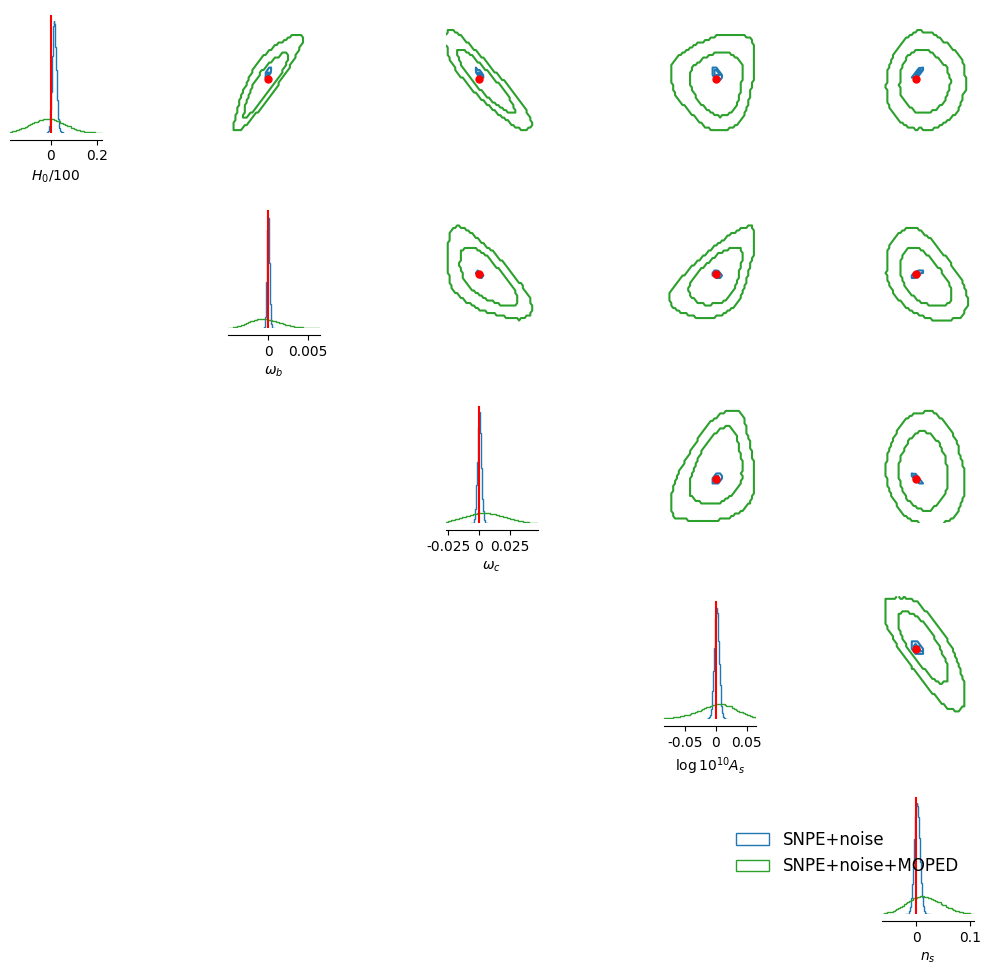

In [11]:
import matplotlib.pyplot as plt
shift_samples_noisy = []
shift_samples = []
samples_l = samples_noisy.tolist()
samples_l_no = samples.tolist()
for i in range(len(samples_l)):
    shift_samples_noisy.append([(samples_l[i][0]-67.6)/100, samples_l[i][1]-0.0224,
                               samples_l[i][2]-0.118, np.log((samples_l[i][3])*10**10)-3.015, 
                               samples_l[i][4]-0.975])
for i in range(len(samples_l_no)):
    shift_samples.append([samples_l_no[i][0]-0.676, samples_l_no[i][1]-0.022,
                               samples_l_no[i][2]-0.122, samples_l_no[i][3]-3.085, 
                               samples_l_no[i][4]-0.964])
shift_samples_noisy = torch.tensor(shift_samples_noisy)
shift_samples = torch.tensor(shift_samples)
fig, axes = analysis.pairplot([shift_samples_noisy,shift_samples  ] , figsize=(10,10), points = torch.tensor([0, 0,0,0,0]),
                     points_colors = 'red', offdiag = 'hist', labels=[r"$H_0 / 100$", r"$\omega_b$", r'$\omega_c$', r'$\log 10^{10} A_s$',
                                                                     r'$n_s$'], upper = 'contour',
                         contour_offdiag=dict(levels=[0.67, 0.95]), hist_diag = dict(density=True))

plt.legend(
    ["SNPE+noise", "SNPE+noise+MOPED"],
    frameon=False,
    fontsize=12,
);
plt.tight_layout()
plt.savefig('sbi_comparison_of_compression_with_noise.pdf')


In [3]:
import camb
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np
import healpy as hp
from tqdm import tqdm
import pickle

# Set the parameters for the CAMB simulation
def sim(params, cls = False):
    # Create a set of cosmological parameters
    pars = camb.CAMBparams()
    H0 = params[0] * 100
    As = 1e-10*np.exp(params[3])
    pars.set_cosmology(H0=H0, ombh2=params[1], omch2=params[2])
    pars.InitPower.set_params(As=As, ns=params[4])
    pars.set_for_lmax(2500, lens_potential_accuracy=0)

    # Get the results from CAMB
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)
    total = powers['total']
    cl = total[:, 0]
    if cls is True: 
        return cl[2:2500]
    else:
        nside = 1024
        cmb_map = hp.sphtfunc.synfast(cl, nside=nside)
        cl_hat = hp.sphtfunc.anafast(cmb_map)
        return cl_hat[2:2500]

def finite_derivative_calc_update(fiducial_vals, size):
    derivatives = []
    for i in tqdm(range(5)):
        step = size[i]
        parr = fiducial_vals.copy()
        parr[i] = fiducial_vals[i] + step
        parr2 = fiducial_vals.copy()
        parr2[i] = fiducial_vals[i] - step
        cl1 = sim(parr, cls = True)
        cl2 = sim(parr2, cls = True)
        derivative = (cl1 - cl2)/(2*step)
        derivatives.append(derivative.tolist())
    return derivatives

fiducial_values = [0.674,  0.0224,  0.120, 3.08, 0.965]
finite_param_steps = [0.0025, 0.0002, 0.0005, 0.0001, 0.001]
fiducial_cls = sim(fiducial_values, cls = True)
finite_derivative = finite_derivative_calc_update(fiducial_values, finite_param_steps)

def cov_matrix(vals):
    ells = np.arange(2561)[2:2500]
    V = np.diag(vals**2) * 2 / ((2*ells+1)*0.6)
    return V

def MOPED(obs):
    obs = obs
    d_minus_mu = obs - fiducial_cls
    d_minus_mu_vector = [[i] for i in d_minus_mu ]
    inverse_cov_matrix = np.linalg.inv(cov_matrix(obs))
    term1 = np.matmul(inverse_cov_matrix, d_minus_mu_vector)
    compressed_stat = np.matmul(finite_derivative, term1)
    result =  [item[0] for item in compressed_stat]
    return result

# Define your simulation function
def simulation_wrapper(params):
    return MOPED(sim(params))
# Your observed parameter values
observed_params = torch.tensor([0.676, 0.0220, 0.122, 3.085, 0.964])

# Generate the observed dataset
observed_dataset = simulation_wrapper(observed_params)
print(observed_dataset )

100%|█████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


[55468.87184718295, -788350.4487103286, 186270.48023596243, -30904.373866533282, -35164.88156211348]


In [8]:
cov_matrix = np.array([
    [5.84486e-07, -6.88207e-06, 1.51690e-05, -1.21513e-13, 3.54448e-05, 7.21747e-06, 2.86100e-04, 3.53847e-05],
    [1.88310e-08, -9.32155e-08, 1.50084e-07, -1.02447e-15, 5.84486e-07, 1.10721e-07, 1.83805e-06, 5.28840e-07]
])
#cov_matrix += cov_matrix.T - np.diag(cov_matrix.diagonal())

_cov  = np.array([[6.11E+00, 0, 0, 0, 0, 0],
                [7.19E-04, 3.26E-07, 0, 0, 0, 0],
                [-1.19E-02, -3.37E-07, 3.14E-05, 0, 0, 0],
                [-3.56E-11, 1.43E-14, 1.76E-13, 5.96E-21, 0, 0],
                [2.01E-02, 6.37E-06, -2.13E-05, 3.66E-13, 1.90E-04, 0],
                [1.10E-02, 2.36E-06, -1.92E-05, 8.70E-13, 7.32E-05, 2.23E-04]])
_cov += _cov.T - np.diag(_cov.diagonal())
print(_cov)

[[ 6.11e+00  7.19e-04 -1.19e-02 -3.56e-11  2.01e-02  1.10e-02]
 [ 7.19e-04  3.26e-07 -3.37e-07  1.43e-14  6.37e-06  2.36e-06]
 [-1.19e-02 -3.37e-07  3.14e-05  1.76e-13 -2.13e-05 -1.92e-05]
 [-3.56e-11  1.43e-14  1.76e-13  5.96e-21  3.66e-13  8.70e-13]
 [ 2.01e-02  6.37e-06 -2.13e-05  3.66e-13  1.90e-04  7.32e-05]
 [ 1.10e-02  2.36e-06 -1.92e-05  8.70e-13  7.32e-05  2.23e-04]]


Running 6000 simulations.: 100%|█████████| 6000/6000 [17:58:02<00:00, 10.78s/it]


 Neural network successfully converged after 139 epochs.

Drawing 200000 posterior samples: 202989it [00:01, 179756.34it/s]               


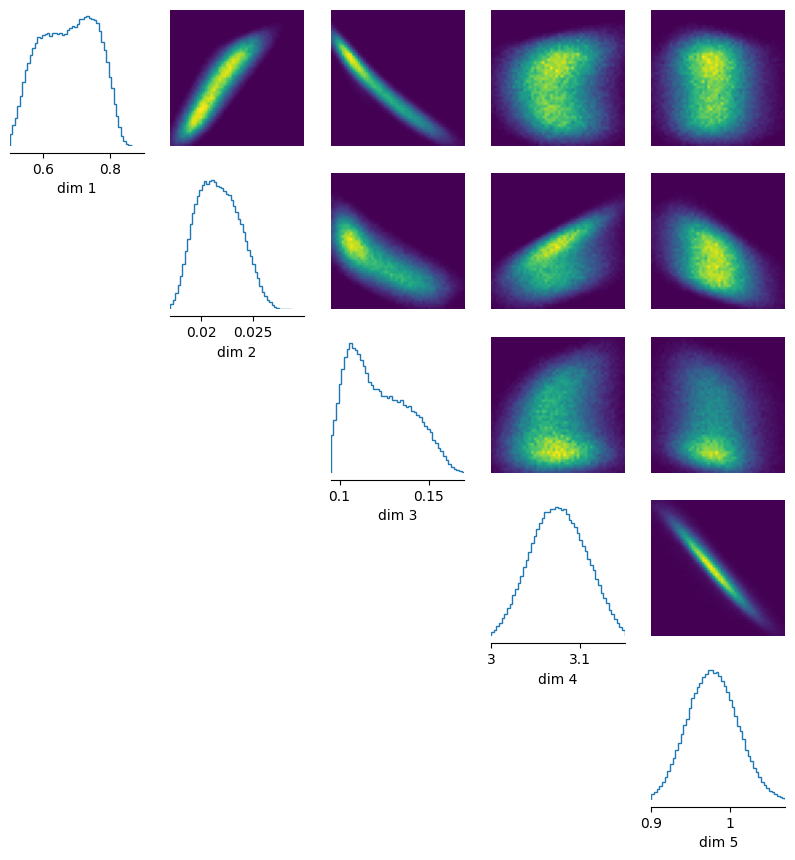

In [4]:
parameter_min = [0.50, 0.017, 0.095, 3.00, 0.9]
parameter_max = [0.90, 0.03, 0.17,3.15, 1.07]

# Define prior for all parameters
prior = utils.BoxUniform(low=torch.as_tensor(parameter_min),
                         high=torch.as_tensor(parameter_max))

num_sim = 6000
# Run SBI to perform inference
posterior = infer(simulation_wrapper, prior, method='SNPE',
                  num_simulations=num_sim, num_workers=1)

num_samples = 200000
# Draw samples from the posterior
samples = posterior.sample((num_samples,), x=observed_dataset)

np.save(f'sbi_{num_sim}_{num_samples}_noisy_moped_1_mar.npy', samples)

with open(f'posterior_{num_sim}_SNPE_noisy_moped_1_mar.pkl', 'wb') as file:
    pickle.dump(posterior, file)

# Analyze the results (for example, by plotting the posterior)
limits_plot = [[parameter_min[i], parameter_max[i]] for i in range(len(parameter_min))]
_ = analysis.pairplot(samples, limits=limits_plot,
                      figsize=(10,10))

In [13]:
samples1d = []
for i in range(len(samples)):
    samples1d.append(samples[i][0])
samples1d = np.array(samples1d)

In [14]:
np.save('samples1d.npy', samples1d)